This notebook shows an example of how to conduct a point-source analysis.
The core of the analysis is a binned poisson likelihood evaluation using Asimov data.
The histograms of the analysis are the effective area, the energy resolution, the angular resolution and the atmospheric background model.
Core functions of the PLEnuM software are used in this example.

In [1]:
%load_ext autoreload
%autoreload 2

# Preparations

In [2]:
# need to run once in the beginning to prepare all ingredients for the analysis
# this might take several minutes

# run these only if you haven't done so before
# load IceCube's effective area and rotate it to approximate other detectors
# %run ../../core/aeff_calculations.py

# calculate the atmospheric neutrino background using MCEq (IceCube-centric)
# %run ../../core/atmospheric_background.py

# run these every time there are updates to resolution, binning, or mephistograms
# load and prepare the energy and angular resolutions
%run ../../core/resolution.py

# gather all ingredients and save them as unified 'mephistogram' data structure
%run ../../core/prepare_histograms.py

file exists: /home/lisajsch/repos/Plenum/local/e_psf_grid_psimax-3_bins-25.pckl
file exists: /home/lisajsch/repos/Plenum/local/energy_smearing_2D_step-0.1.pckl
140 log_10(energy) bins
100 declination bins
140 log_10(energy) bins
100 declination bins
Elementary arithmetic possible.
True


# Imports

In [3]:
import pickle
from collections import namedtuple
from itertools import product
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
    cut_off,
    power_law,
)
import mephisto
from matplotlib.colors import LogNorm
from scipy.interpolate import splev, splrep
from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import chi2, norm
from settings import *
from tools import array_source_interp, poisson_llh
from tqdm import tqdm


# Default binning

In [4]:
print(len(logE_bins), np.min(logE_bins), np.max(logE_bins))
print(len(logE_reco_bins), np.min(logE_reco_bins), np.max(logE_reco_bins))
print(len(sindec_bins), np.min(sindec_bins), np.max(sindec_bins))


141 2.0 8.999999999999975
140 2.0 8.949999999999974
101 -1.0 1.0


# Source parameters

In [5]:
# livetime of 10yrs in seconds and days
print(LIVETIME, LIVETIME / 24 / 3600)
# Normalization energy of power law (E/E_NORM)^GAMMA_ASTRO
print(E_NORM)  # in GeV
# Source flux spectral index
# see https://arxiv.org/abs/2111.10299?context=astro-ph
print(GAMMA_ASTRO)  # spectral index
print(PHI_ASTRO)  # neutrinos * (E/E_NORM)^GAMMA_ASTRO / GeV / cm^2 / s / sr
print(BASEPATH)
print(LOCALPATH)


275270400 3186.0
100000.0
2.37
1.44e-18
/home/lisajsch/repos/Plenum
/home/lisajsch/repos/Plenum/local


# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

dict_keys(['Plenum-1', 'IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD', 'Gen-2', 'Plenum-2'])
Mephistogram with 2 dimensions and shape (100, 140). Axis names are ('sin(dec)', 'log(E/GeV)').
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [13.47937914 13.47937914 16.64221592 ... 23.82743744  0.
   0.        ]
 [17.02848656 17.02848656 20.63478084 ... 20.27620928  0.
   0.        ]
 [19.13943583 19.13943583 22.97704711 ... 18.70430083  0.
   0.        ]]


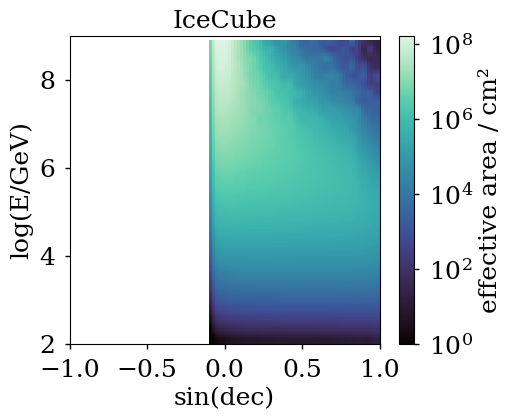

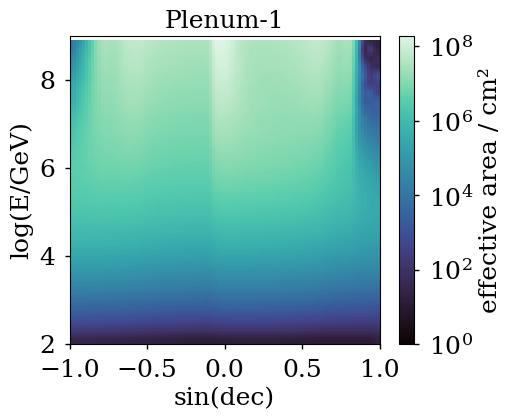

In [6]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)
print(aeff_2d.keys())
print(aeff_2d["IceCube"])  # mephistogram data structure for histograms+binning

# plot the effective area
for key in ["IceCube", "Plenum-1"]:
    mephisto.plot_mephistogram(aeff_2d[key], norm=LogNorm(vmin=1))
    cb = plt.colorbar()
    cb.set_label("effective area / cm²")
    plt.title(key)


# Background

Elementary arithmetic possible.
True


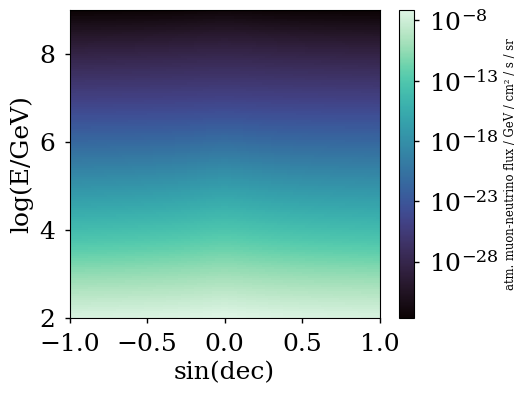

In [5]:
# MCEQ: atmospheric flux on muon neutrinos (see also 'background_flux.ipynb')
with open(join(LOCALPATH, "atmospheric_background_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histograms are matching, i.e. have the same binning
print(bckg_histo.match(aeff_2d["IceCube"], verbose=True))

# visualization of bckg flux
mephisto.plot_mephistogram(bckg_histo, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("atm. muon-neutrino flux / GeV / cm² / s / sr", fontsize="small")


# Energy smearing

In [9]:
from matplotlib.colors import ListedColormap, LogNorm
cmap = ListedColormap(sns.color_palette("mako", n_colors=12))

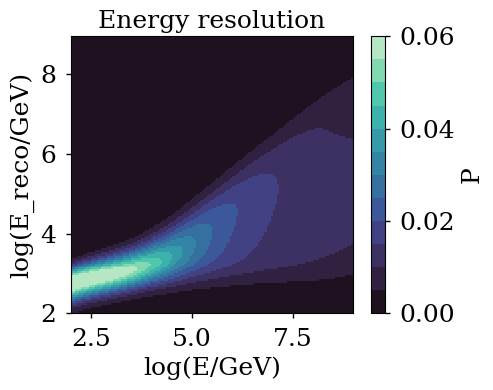

In [15]:
# energy smearing matrix
with open(join(LOCALPATH, "energy_smearing_MH_up.pckl"), "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1)

f, ax = mephisto.plot_mephistogram(baseline_eres, cmap=cmap, vmax=0.06, vmin=0)
cb = plt.colorbar()
cb.set_label("P")
ax.set_title("Energy resolution")
f.tight_layout()
#f.savefig("../../plots/eres-icecube.png")

# Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

In [17]:
# angular resolution
with open(join(LOCALPATH, "Psi2_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()

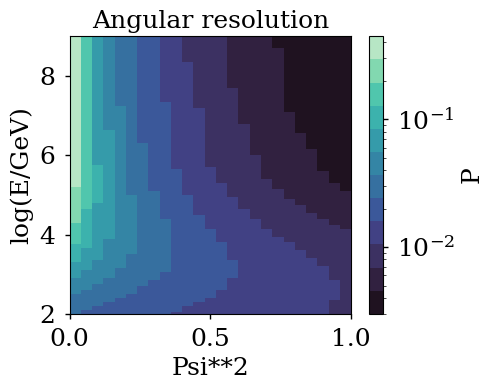

In [27]:
f, ax = mephisto.plot_mephistogram(e_psi2_grid, norm=LogNorm(vmin=3E-3), cmap=cmap)
cb = plt.colorbar()
cb.set_label("P")
ax.set_xlim(0, 1)
ax.set_title("Angular resolution")
f.tight_layout()
#f.savefig("../../plots/psi2res-icecube.png")

# Source flux definition
$N_{\nu} = T_{\rm live} \cdot \int_{\Delta \Omega} d \Omega \, d E \, \int_{E_{\min}}^{E_{\max}} dE \, A_{\rm eff} \left( E, \sin(\delta)\right) \cdot \frac{d \Phi}{d E} $

Approximate the integral with a finite-binning approach:

aeff_factor =
$ 2\pi \cdot \Delta \sin (\delta) \, \Delta E \cdot A_{\rm eff} \left( E, \sin(\delta)\right) $ 

($2\pi = \int_0^{2\pi} d\phi$; $d \Omega = d \phi \cdot d \sin(\delta)$)

In [9]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")


In [10]:
# ngc1068 source config
ngc_src_config = dict(
    sindec_mids=sindec_mids,
    livetime=LIVETIME,
    ewidth=ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
    dec=ngc1068.dec.rad,
)
# corresponding bg config
ngc_bg_config = copy(ngc_src_config)
ngc_bg_config["dpsi_max"] = delta_psi_max
ngc_bg_config["grid_2d"] = bckg_psi2_grid



## Check event numbers

In [11]:
ident = "IceCube"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

k_s = astro_flux(
    aeff_factor_signal,
    emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))  # ~85


ngc 1068: 85.16199270234627


# Asimov histograms in Psi² - log(E)

Fit parameters for analysis:
* Global normalization of k_b
* Global normalization of k_s
* Spectral index of k_s (=gamma)

In [13]:
ident = "IceCube"

aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

# asimov data
k_b = atmo_background(
    aeff_factor=aeff_factor_bckg,
    bckg_vals=array_source_interp(
        ngc_src_config["dec"], bckg_histo, sindec_mids, axis=1
    ),
    energy_resolution=baseline_eres,
)
# power law
k_s = astro_flux(
    aeff_factor=aeff_factor_signal,
    emids=emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,  # powerlaw
)
k_i = k_s + k_b

print("Asimov data sum:")
print("Background:", np.sum(k_b))  # ~1170
print("Signal:", np.sum(k_s))  # ~85
print("S+B", np.sum(k_i))

Asimov data sum:
Background: 1171.0715267504427
Signal: 85.16199270234627
S+B 1256.2335194527889


In [14]:
print(k_s) # mephistogram data structure for histograms+binning

Mephistogram with 2 dimensions and shape (225, 139). Axis names are ('Psi**2', 'log(E_reco/GeV)').
[[8.57209588e-03 1.04046739e-02 1.40698300e-02 ... 3.88538267e-12
  2.60475194e-12 3.37945242e-16]
 [6.96955810e-03 8.45366508e-03 1.14218790e-02 ... 1.29786235e-12
  8.68280824e-13 2.50189748e-16]
 [5.96523370e-03 7.23256027e-03 9.76721342e-03 ... 6.72241019e-13
  4.49375102e-13 2.01964547e-16]
 ...
 [1.06471837e-04 1.28404919e-04 1.72271083e-04 ... 8.24984625e-16
  5.50171394e-16 2.21030874e-18]
 [1.05711520e-04 1.27487504e-04 1.71039472e-04 ... 8.18359556e-16
  5.45746193e-16 2.19396441e-18]
 [1.04959251e-04 1.26579808e-04 1.69820921e-04 ... 8.11814832e-16
  5.41374899e-16 2.17780139e-18]]


## Plotting the histograms

Text(0.5, 1.0, 'Signal astrophysical flux')

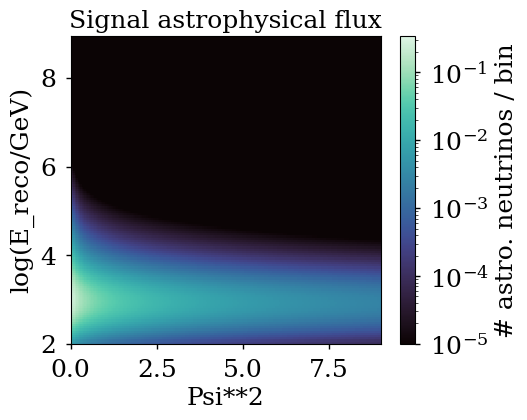

In [20]:
## signal
k_s.plot(norm=LogNorm(vmin=1E-5))
cb = plt.colorbar()
cb.set_label("# astro. neutrinos / bin")
plt.title("Signal astrophysical flux")

Text(0.5, 1.0, 'Background atmospheric flux')

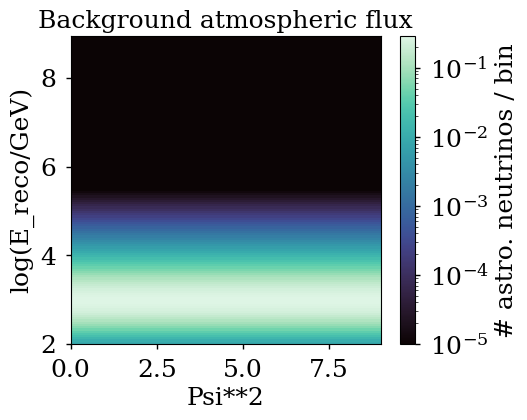

In [19]:
## background
k_b.plot(norm=LogNorm(vmin=1E-5))
cb = plt.colorbar()
cb.set_label("# astro. neutrinos / bin")
plt.title("Background atmospheric flux")

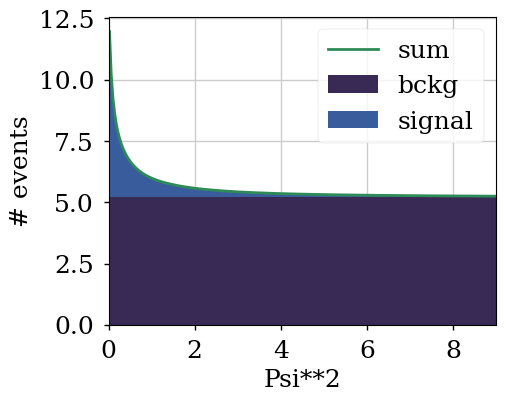

In [26]:
# summed 1D hist in psi²
f, axes = plt.subplots(figsize=(5, 4))
mephisto.plot_multiple_mephistograms(
    (k_b.sum(axis=1, return_mephisto=True), k_s.sum(axis=1, return_mephisto=True)),
    labels=["bckg", "signal"],
    f=f,
    axes=axes,
)
k_i_en = k_i.sum(axis=1, return_mephisto=True)
plt.plot(k_i_en.bin_mids, k_i_en.histo, label="sum", color="seagreen")

plt.ylabel("# events")
plt.legend()

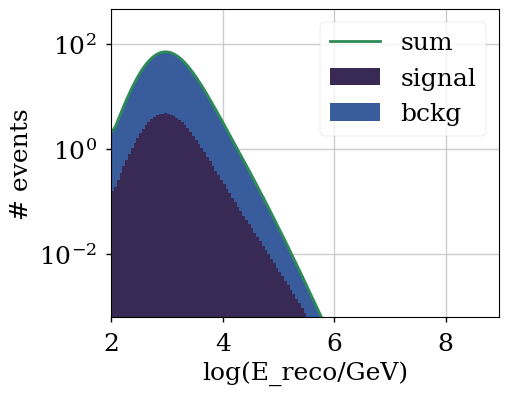

In [23]:
# summed 1D hist in log(E_reco)
f, axes = plt.subplots(figsize=(5, 4))
mephisto.plot_multiple_mephistograms(
    (k_s.sum(axis=0, return_mephisto=True), k_b.sum(axis=0, return_mephisto=True)),
    labels=["signal", "bckg"],
    f=f,
    axes=axes,
)
k_i_en = k_i.sum(axis=0, return_mephisto=True)
plt.plot(k_i_en.bin_mids, k_i_en.histo, label="sum", color="seagreen")

plt.yscale("log")
plt.ylabel("# events")
plt.legend()

# DEMO: Significance test 
Background vs. Background + Signal

## Set up LLH function
$ \mathcal{L}({\rm data}~k~ |~{\rm hypothesis}~\mu)
    = \prod_{{\rm bin\,}ij}^{N_{\rm bins}} \frac{\mu_{ij}^{k_{ij}}}{k_{ij}!}\cdot
    \exp \left( -\mu_{ij} \right)$


Background hypothesis $H_0(\mu = N_B)$ : only atmospheric neutrino flux

Signal hypothesis $H_1(\mu = \{N_B, N_S, \gamma\})$: atmospheric neutrino flux + astrophysical neutrino flux

Idea: data ($k$) are the perfect representation of our expectation; the hypothesis ($\mu$) is the model with the free parameters we'd like to know


For numerical stability, we directly evaluate (see https://en.wikipedia.org/wiki/Stirling%27s_approximation for approximation of the faculty function)
$-2 \log (\mathcal{L}) = -2\cdot (k_i \cdot \log(\mu_i)
            - \mu_i
            - 0.5 \cdot \log(2 \pi \cdot k_i)
            + k_i
            - k_i \cdot \log(k_i))$
* mu -> 0, k>0     --> P -> 0
* k -> 0, mu>0     --> P -> exp(-mu)
* k -> 0, mu -> 0  --> P -> 1


In [27]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0,
    phi_0,
    energy_resolution,
):
    """fit parameters in x:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling
    x[2]: signal spectral index
        see 'astro_flux' for further shapes and parameters

    mu_b_base: background baseline
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_0: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    """
    mu_b = mu_b_base * x[0]
    mu_s = astro_flux(
        mu_s_base,
        emids,
        energy_resolution,
        x[1],
        PL_flux(
            phi_0, x[2], e_0, "powerlaw"
        ),  # here we generate a flux tuple with the current parameters
    )
    mu_i = mu_s + mu_b

    return poisson_llh(mu_i, k_i)


## Do the fit

In [29]:
ident = "IceCube"

aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

# asimov data
k_b = atmo_background(
    aeff_factor=aeff_factor_bckg,
    bckg_vals=array_source_interp(ngc_src_config["dec"], bckg_histo, sindec_mids, axis=1),
    energy_resolution=baseline_eres,
)
# power law
k_s = astro_flux(
    aeff_factor=aeff_factor_signal,
    emids=emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,  # powerlaw
)
k_i = k_s + k_b

print("Asimov data sum:")
print("Background:", np.sum(k_b))
print("Signal:", np.sum(k_s))


dct = dict(
    mu_b_base=k_b,
    mu_s_base=aeff_factor_signal,
    k_i=k_i,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
    energy_resolution=baseline_eres,
)

# fix signal normalization to 0
local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **dct)
global_llh = lambda x: ps_llh_2d_composite(x, **dct)

out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1,),
    approx_grad=True,
)
print("Atmo-only normalization:", out_bckg[0])

# this fit is not really needed, but good for crosschecking the code
out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1, 1, ngc_flux.gamma),
    approx_grad=True,
)
print("Signal fit parameters:", out_comp[0])
print("TS check:", global_llh((1, 1, ngc_flux.gamma)), "(fit: ", out_comp[1], ")")
print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
significance = norm.isf(pval)
print("P-VALUE:", pval, "SIGNIFICANCE:", significance)

Asimov data sum:
Background: 1171.0715267504427
Signal: 85.16199270234627
Atmo-only normalization: [1.07271294]
Signal fit parameters: [1.  1.  3.2]
TS check: -350386.0769970139 (fit:  -350386.0769970139 )
-2 Delta LLH: 20.42661781888455
P-VALUE: 3.6678899658089966e-05 SIGNIFICANCE: 3.965124009957658
